## Application: Labor Participation
---

#### Variables:

+ work - participation in 1975 ? (error: "no" must be "yes")
+ hoursw - wife's hours of work in 1975
+ child6 - number of children less than 6 years old in household
+ child618 - number of children between ages 6 and 18 in household
+ agew - wife's age
+ educw - wife's educational attainment, in years
+ hearnw - wife's average hourly earnings, in 1975 dollars
+ wagew - wife's wage reported at the time of the 1976 interview (not= 1975 estimated wage)
+ hoursh - husband's hours worked in 1975
+ ageh - husband's age
+ educh - husband's educational attainment, in years
+ wageh - husband's wage, in 1975 dollars
+ income - family income, in 1975 dollars
+ educwm - wife's mother's educational attainment, in years
+ educwf - wife's father's educational attainment, in years
+ unemprate - unemployment rate in county of residence, in percentage points
+ city - lives in large city (SMSA) ?
+ experience - actual years of wife's previous labor market experience

#### Source:

Mroz - Labor Supply Data

https://vincentarelbundock.github.io/Rdatasets/datasets.html

Mroz, T. (1987) “The sensitivity of an empirical model of married women's hours of work to economic and statistical assumptions”, Econometrica, 55, 765-799.


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from IPython.display import display

#### Labor participation

$$
 y_i = \begin{cases} 1, & \text{not work}; \\ 0, & \text{work}. \end{cases}
$$

$$
 \log\frac{\mu}{1-\mu}
 = \text{constant}
 + \beta_1(\text{hoursh}\times\text{wageh}\div 1000)
 + \beta_2\text{univ}
 + \beta_3\text{city}
 + \beta_4\text{experience}
 + \beta_5\text{child6}
 + \beta_6\text{unemprate}
$$

where

$$
 \text{univ} = \begin{cases} 1, & \text{university gradaute or higher};\\ 0, & \text{otherwise}. \end{cases}.
$$


In [2]:
data = pd.read_csv('Mroz.csv', index_col=0)
earnings = data['hoursh'].values * data['wageh'].values / 1000
age = data['agew'].values
dummy_univ = (data['educw'].values >= 16)
dummy_city = data['city'].replace(['yes', 'no'], [1, 0]).values
y = data['work'].replace(['yes', 'no'], [0, 1]).values
X = np.hstack((np.vstack((np.ones(y.size), earnings, dummy_univ, dummy_city)).T,
              data[['experience', 'child6', 'unemprate']].values))
var_names = ['constant', 'earnings', 'university', 'city', 'experience', 'child6', 'unemprate']

In [3]:
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
logit_model = pm.Model()
with logit_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Bernoulli('y', logit_p=idx, observed=y)
n_draws = 5000
n_chains = 4
n_tune = 1000
with logit_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
results = pm.summary(trace)
results.index = var_names
sim_param = dict([(var, trace.posterior['b'].values[:, :, index]) for index, var in enumerate(var_names)])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 17 seconds.


In [4]:
display(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
constant,-0.064,0.303,-0.646,0.483,0.002,0.002,17953.0,14028.0,1.0
earnings,-0.022,0.010,-0.039,-0.003,0.000,0.000,20987.0,14134.0,1.0
university,1.268,0.278,0.725,1.765,0.002,0.001,23649.0,14903.0,1.0
city,-0.005,0.183,-0.339,0.352,0.001,0.001,23211.0,13449.0,1.0
experience,0.095,0.012,0.071,0.117,0.000,0.000,22619.0,13987.0,1.0
child6,-0.763,0.168,-1.079,-0.449,0.001,0.001,21808.0,14353.0,1.0
unemprate,-0.025,0.027,-0.074,0.027,0.000,0.000,21311.0,14481.0,1.0


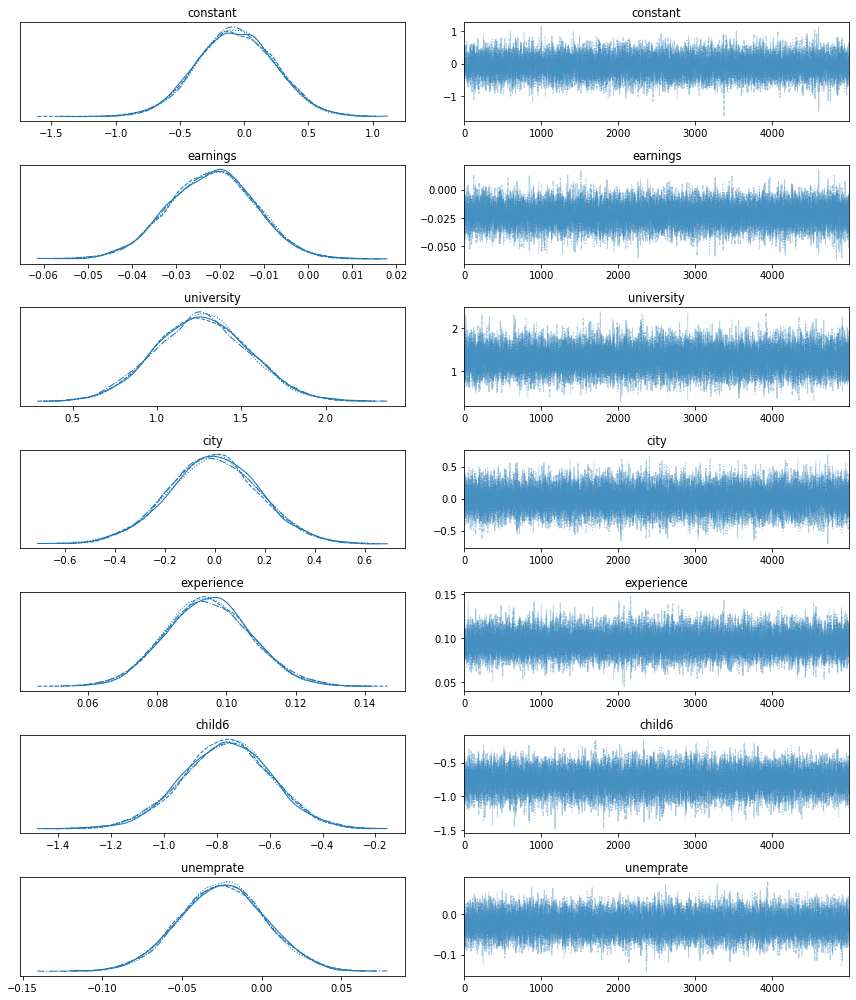

In [5]:
pm.plot_trace(sim_param)
plt.tight_layout()
plt.show()

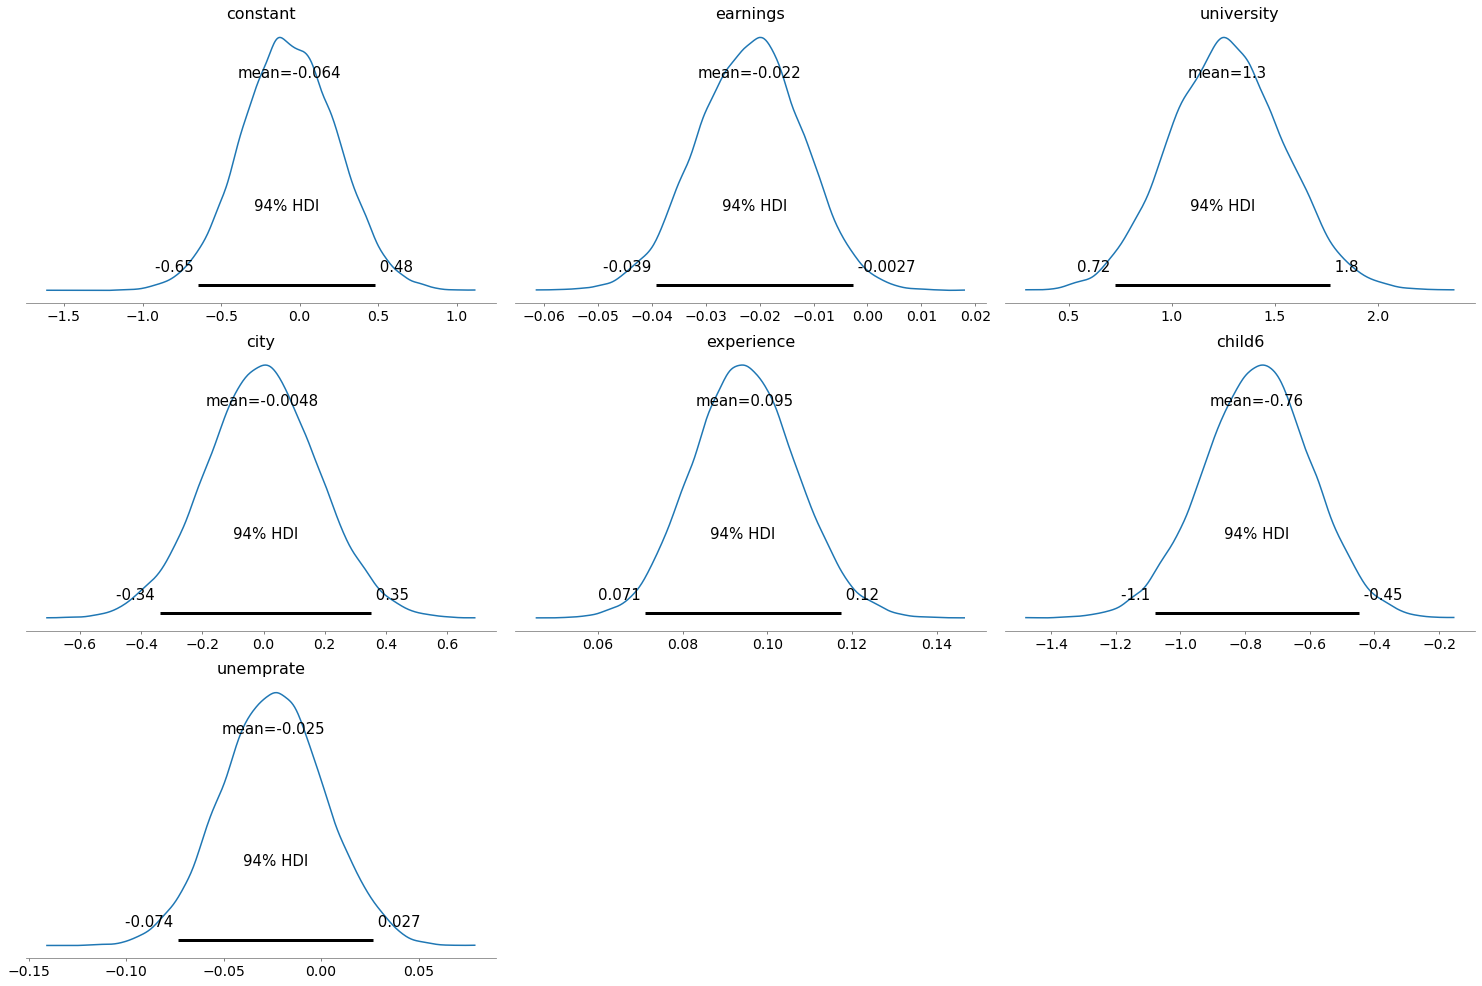

In [6]:
pm.plot_posterior(sim_param, kind='kde', point_estimate='mean')
plt.tight_layout()
plt.show()